# Experiment A: Bound Adherence Under Nonstationary Conditions
*Question: does empirical average regret stay within the $\gamma$-regret bounds?*

### Experiment Design
Grid search over the streams (stationary, slow, abrupt, periodic), lambda levels, and two deletion ratio regimes.

Use a static comparator and calibrated learning rate schedule.
Set gamma per-theory at calibration and fix the total horizon (ie. $T=50000$).

### Primary Analysis
For each of the experimental cells, evaluate the final $R_{T}/T$ to see whether the guarantee was met.
Multiple seeds per cell in order to make some kind of causal analysis on the results.

### Success Criteria
95% of the cells meet their guarantees then I would call that a success. Which cells experience more successes than others? Can I make a heatmap that shows the regret results per cell?

In [1]:
import os
import sys


In [2]:
# Get the current working directory (optional, for verification)
current_directory = os.getcwd()
print(f"Current directory: {current_directory}")

# Change the working directory to the parent directory
os.chdir('..')

# Get the new current working directory (optional, for verification)
new_directory = os.getcwd()
print(f"New current directory: {new_directory}")


Current directory: /workspaces/unlearning-research-meta/experiments/deletion_capacity/notebooks
New current directory: /workspaces/unlearning-research-meta/experiments/deletion_capacity


In [3]:
# 1) Preamble and helpers

import os, json, glob, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
sns.set_context("talk")

# Change this to your latest sweep directory
BASE_DIR = "results/grid_2025_08_31_p4/sweep"
random.seed(42)

In [4]:
def list_grid_cells(base_dir: str):
    # each grid cell is a directory under .../sweep/
    return sorted([os.path.join(base_dir, d) for d in os.listdir(base_dir)
                   if os.path.isdir(os.path.join(base_dir, d))])

def sample_grid_cells(dir_list, k=3):
    return random.sample(dir_list, min(k, len(dir_list)))

def load_params(grid_path: str) -> dict:
    p = os.path.join(grid_path, "params.json")
    if os.path.exists(p):
        with open(p, "r") as f:
            return json.load(f)
    return {}

def _find_event_csvs(grid_path: str):
    # Prefer explicit event-level files if present
    event_level = glob.glob(os.path.join(grid_path, "seed_*_events.csv"))
    if event_level:
        return sorted(event_level)
    # Fallback: use seed-run CSVs (often contain per-event rows, e.g., runner outputs)
    seed_like = glob.glob(os.path.join(grid_path, "seed_*.csv"))
    # Filter out seed-level one-row summaries (we'll treat all as events and aggregate)
    return sorted(seed_like)

def _find_seed_summary_csvs(grid_path: str):
    # Seed-level output from agents/process_seed_output -> one row per seed
    return sorted([p for p in glob.glob(os.path.join(grid_path, "seed_*.csv"))
                   if "_events" not in p])

def load_seed_summary(grid_path: str) -> pd.DataFrame:
    paths = _find_seed_summary_csvs(grid_path)
    rows = []
    for p in paths:
        try:
            df = pd.read_csv(p)
            # Detect single-row seed summary; if multi-row, keep last row
            if len(df) > 1 and "event" in df.columns:
                # This is an event-level CSV; skip here
                continue
            df["__source__"] = os.path.basename(p)
            rows.append(df.iloc[[-1]].copy())
        except Exception:
            pass
    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()

def load_event_csvs(grid_path: str, usecols=None) -> pd.DataFrame:
    paths = _find_event_csvs(grid_path)
    rows = []
    for p in paths:
        try:
            df = pd.read_csv(p, usecols=usecols)
            # Add grid metadata
            df["grid_id"] = os.path.basename(grid_path)
            # Try to infer seed from file name
            base = os.path.basename(p)
            try:
                # seed_001 or seed_001_...
                sid = int(base.split("_")[1])
            except Exception:
                sid = np.nan
            df["seed"] = sid
            rows.append(df)
        except Exception as e:
            print(f"Warning: failed to read {p}: {e}")
    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()

In [5]:
def compute_acceptance_metrics(df_events: pd.DataFrame, params: dict) -> dict:
    # Targets (may be missing)
    tPT = params.get("target_PT", np.nan)
    tST = params.get("target_ST", np.nan)
    tG  = params.get("target_G",  np.nan)
    rho_total = params.get("rho_total", np.nan)

    # Observables (guard against missing columns)
    PT_final = float(df_events["P_T_true"].iloc[-1]) if "P_T_true" in df_events.columns and len(df_events) else np.nan
    ST_final = (float(df_events["ST_running"].iloc[-1]) if "ST_running" in df_events.columns and len(df_events)
                else (float(df_events["S_scalar"].iloc[-1]) if "S_scalar" in df_events.columns and len(df_events) else np.nan))
    max_g = float(df_events["g_norm"].max()) if "g_norm" in df_events.columns else np.nan
    clip_rate = float(df_events["clip_applied"].mean()) if "clip_applied" in df_events.columns else np.nan

    rho_spent = np.nan
    if "privacy_spend_running" in df_events.columns:
        rho_spent = float(df_events["privacy_spend_running"].iloc[-1])
    elif "rho_spent" in df_events.columns:
        rho_spent = float(df_events["rho_spent"].iloc[-1])

    # AT-1 fix: scale PT target by effective horizon consumed
    T_nom = params.get("max_events", np.nan)
    if np.isfinite(tPT) and np.isfinite(T_nom) and T_nom > 0 and np.isfinite(PT_final):
        T_eff = int(df_events["event"].iloc[-1]) + 1 if ("event" in df_events.columns and len(df_events)) else len(df_events)
        PT_target_eff = tPT * (T_eff / T_nom)
        PT_err = abs(PT_final / PT_target_eff - 1.0)
    else:
        PT_err = abs(PT_final / tPT - 1.0) if (np.isfinite(PT_final) and np.isfinite(tPT) and tPT != 0) else np.nan

    ST_err = abs(ST_final / tST - 1.0) if (np.isfinite(ST_final) and np.isfinite(tST) and tST != 0) else np.nan

    AT1 = (PT_err <= 0.05) if np.isfinite(PT_err) else None # analysis task 1
    if np.isfinite(tG):
        cond_g = (max_g <= 1.05 * tG) if np.isfinite(max_g) else False
        cond_clip = (clip_rate <= 0.05) if np.isfinite(clip_rate) else True
        AT2 = (cond_g and cond_clip) # analysis task 2
    AT5 = (ST_err <= 0.05) if np.isfinite(ST_err) else None # analysis task 5
    AT6 = (rho_spent <= rho_total) if (np.isfinite(rho_total) and np.isfinite(rho_spent)) else None # analysis task 6

    return {
        "PT_final": PT_final, "PT_error": PT_err,
        "ST_final": ST_final, "ST_error": ST_err,
        "max_g_norm": max_g, "avg_clip_rate": clip_rate,
        "rho_spent_final": rho_spent,
        "AT1_PT": AT1, "AT2_G_clip": AT2, "AT5_ST": AT5, "AT6_privacy": AT6,
    }

### AT-1: Path-length adherence ($P_{T}$)
- What it tests: That the realized comparator path length `P_T_true` over the run tracks the `target_PT` specified by the theory-first stream, within 5% at the end. This is a proxy for “how much drift” the comparator is allowed and is the path term that appears in dynamic-regret bounds (the $G \cdot P_{T}$ piece).
- Why it matters: If $P_T$ is too large, dynamic regret bounds (and often the realized dynamic regret) inflate linearly with $P_T$, even if everything else is calibrated.
- Result interpretation: Failed in all three sampled cells with large positive error (~+129%). $S_T$ and $G$ targets were met, so this looks like a $P_{T}$ controller/instrumentation mismatch, not a global scaling problem. Likely next checks:
  - Confirm the rotation-based $P_{T}$ controller uses `w_norm` = `target_D`/2 in `set_rotation_by_PT` (consistent with its docstring).
  - Check that $P_T$ increments aren’t double-counted and that the final $P_T$ comparison uses the effective horizon T actually consumed.

In [6]:
def quick_panel_plots(df: pd.DataFrame, params: dict, title: str = ""):
    # Guard: minimal columns only
    has_PT = "P_T_true" in df.columns
    has_ST = "ST_running" in df.columns or "S_scalar" in df.columns
    has_g  = "g_norm" in df.columns
    has_priv = "privacy_spend_running" in df.columns or "rho_spent" in df.columns

    T = len(df)
    steps = np.arange(T)

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(title or os.path.basename(params.get("__grid_path__", "")), fontsize=14)

    # 1) Path length
    ax = axes[0, 0]
    if has_PT:
        ax.plot(steps, df["P_T_true"].values, 'b-', alpha=0.85, label='Actual P_T')
        if np.isfinite(params.get("target_PT", np.nan)):
            # AT-1 fix: scale target line by event ids over nominal horizon
            T_nom = params.get("max_events", T)
            events_axis = df["event"].values if "event" in df.columns else steps
            ax.plot(steps, params["target_PT"] * events_axis / max(T_nom, 1), 'r--', label='Target P_T')
        ax.set_title("AT-1: Path Length")
        ax.set_xlabel("Step"); ax.set_ylabel("P_T")
        ax.grid(True, alpha=0.3); ax.legend()
    else:
        ax.text(0.5, 0.5, "No P_T_true", ha="center", va="center")
        ax.axis("off")

    # 2) g-norms
    ax = axes[0, 1]
    if has_g:
        ax.plot(steps, df["g_norm"].values, 'g-', alpha=0.7, label='g_norm')
        if np.isfinite(params.get("target_G", np.nan)):
            ax.axhline(params["target_G"], color='r', ls='--', label=f"Target G")
        ax.set_title("AT-2: Gradient Bound")
        ax.set_xlabel("Step"); ax.set_ylabel("||g||")
        ax.grid(True, alpha=0.3); ax.legend()
    else:
        ax.text(0.5, 0.5, "No g_norm", ha="center", va="center")
        ax.axis("off")

    # 3) ST
    ax = axes[1, 0]
    if has_ST:
        st_series = df["ST_running"].values if "ST_running" in df.columns else df["S_scalar"].values
        ax.plot(steps, st_series, color="purple", label="Actual S_T")
        if np.isfinite(params.get("target_ST", np.nan)):
            ax.plot(steps, params["target_ST"] * steps / max(T, 1), 'orange', ls='--', label='Target S_T')
        ax.set_title("AT-5: AdaGrad Energy")
        ax.set_xlabel("Step"); ax.set_ylabel("S_T")
        ax.grid(True, alpha=0.3); ax.legend()
    else:
        ax.text(0.5, 0.5, "No ST_running/S_scalar", ha="center", va="center")
        ax.axis("off")

    # 4) privacy
    ax = axes[1, 1]
    if has_priv:
        y = (df["privacy_spend_running"].values if "privacy_spend_running" in df.columns
             else df["rho_spent"].values)
        ax.plot(steps, y, color="brown", label="rho spent")
        if np.isfinite(params.get("rho_total", np.nan)):
            ax.axhline(params["rho_total"], color="r", ls='--', label="rho budget")
        ax.set_title("AT-6: Privacy Spend (rho)")
        ax.set_xlabel("Step"); ax.set_ylabel("rho")
        ax.grid(True, alpha=0.3); ax.legend()
    else:
        ax.text(0.5, 0.5, "No privacy spend", ha="center", va="center")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [7]:
grid_dirs = list_grid_cells(BASE_DIR)
print(f"Found {len(grid_dirs)} grid cells")
sampled = sample_grid_cells(grid_dirs, k=3)
sampled

Found 108 grid cells


['results/grid_2025_08_31_p4/sweep/gamma_1.5-split_0.7_q0.95_k10_zcdp_rho2.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_PT100_ST40000_G2.00_lam0.05_c0.1-C10_had7936d5',
 'results/grid_2025_08_31_p4/sweep/gamma_0.6-split_0.5_q0.95_k1_zcdp_rho0.5_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_PT250_ST40000_G2.00_lam0.05_c0.1-C10_h5b64ec2a',
 'results/grid_2025_08_31_p4/sweep/gamma_0.6-split_0.5_q0.95_k10_zcdp_rho0.5_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_PT250_ST40000_G2.00_lam0.05_c0.1-C10_ha4fd7e6b']


=== Grid: gamma_1.5-split_0.7_q0.95_k10_zcdp_rho2.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_PT100_ST40000_G2.00_lam0.05_c0.1-C10_had7936d5 ===
{'gamma_bar': 1.5, 'gamma_split': 0.7, 'algo': 'memorypair', 'accountant': 'zcdp', 'max_events': 20000, 'bootstrap_iters': 1000, 'delete_ratio': 10, 'rho_total': 2.0, 'delta_total': '1e-5', 'delta_b': 0.05, 'm_max': None, 'quantile': 0.95, 'D_cap': 10.0, 'ema_beta': 0.9, 'strong_convexity': True, 'lambda_reg': 0.01, 'lambda_': 0.05, 'dim': 20, 'path_style': 'rotating', 'target_G': 2.0, 'target_D': 2.0, 'target_c': 0.1, 'target_C': 10.0, 'target_lambda': 0.05, 'target_PT': 100.0, 'target_ST': 40000.0, 'enable_oracle': False, 'eps_total': 1.0, '__grid_path__': 'results/grid_2025_08_31_p4/sweep/gamma_1.5-split_0.7_q0.95_k10_zcdp_rho2.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_PT100_ST40000_G2.00_lam0.05_c0.1-C10_had7936d5'}


,seed,avg_regret_empirical,N_star_emp,m_emp,PT_final,PT_error,ST_final,ST_error,max_g_norm,avg_clip_rate,rho_spent_final,blocked_reason
0,2,0.153237,17228,1722,NaN,NaN,253237.577758,5.330939,NaN,NaN,NaN,AT-5 ST err 533.1%
1,3,0.218013,17228,1722,235.968330,1.359683,39996.000000,0.000100,1.414214,0.0,0.0,AT-1 PT err 136.0%
2,4,0.149639,17228,1722,229.056395,1.290564,39996.000000,0.000100,1.414214,0.0,0.0,AT-1 PT err 129.1%


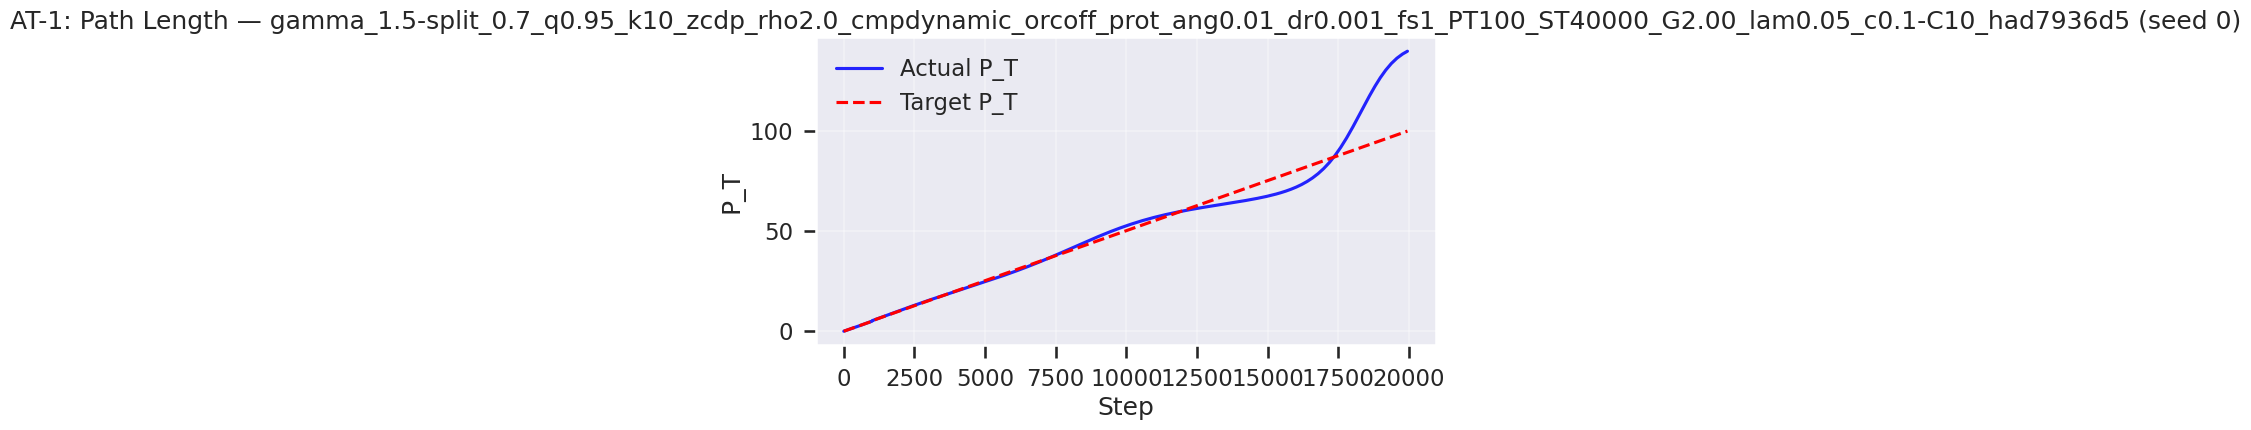

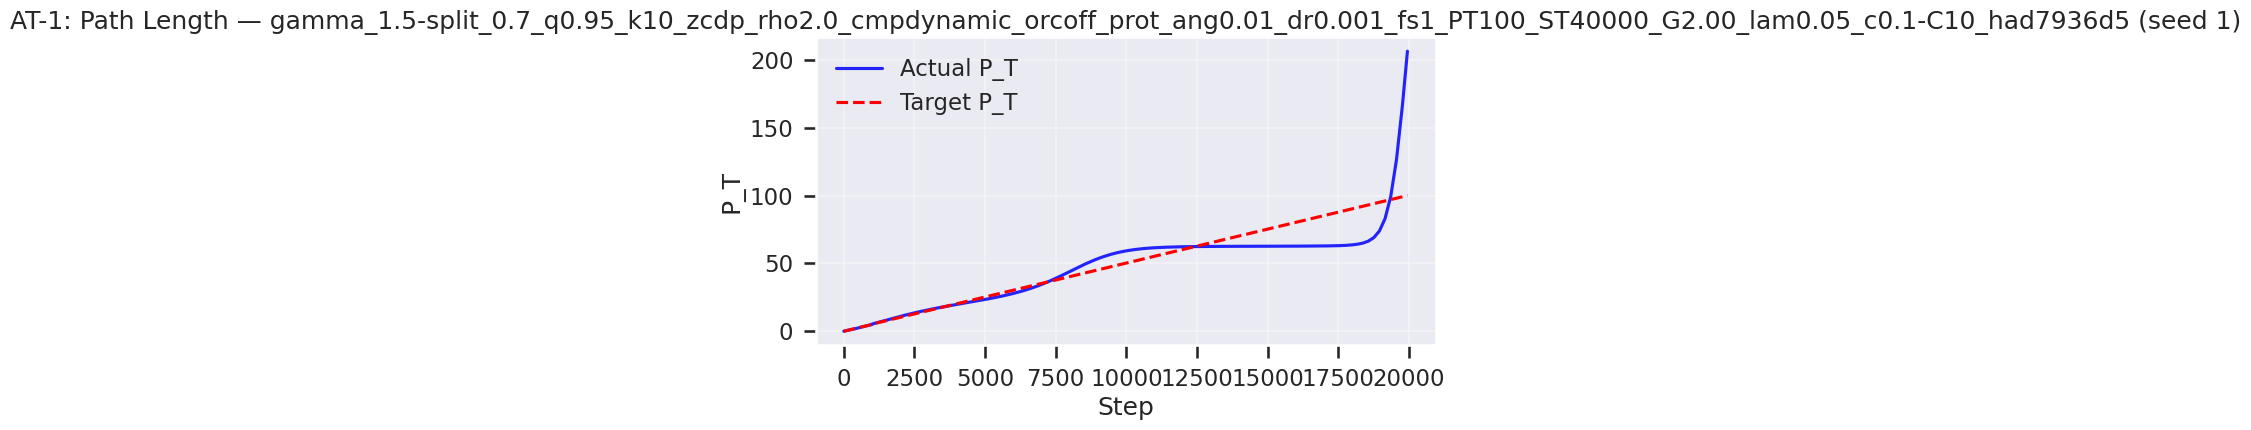

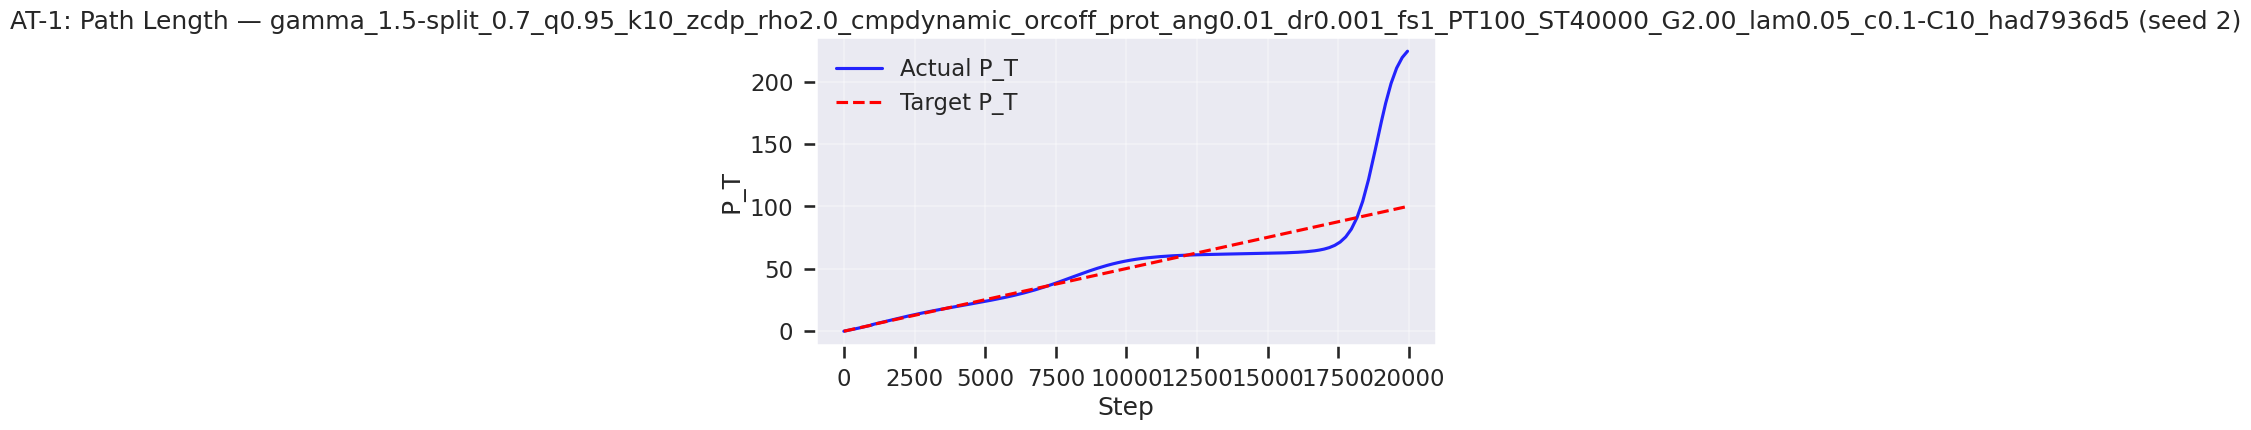

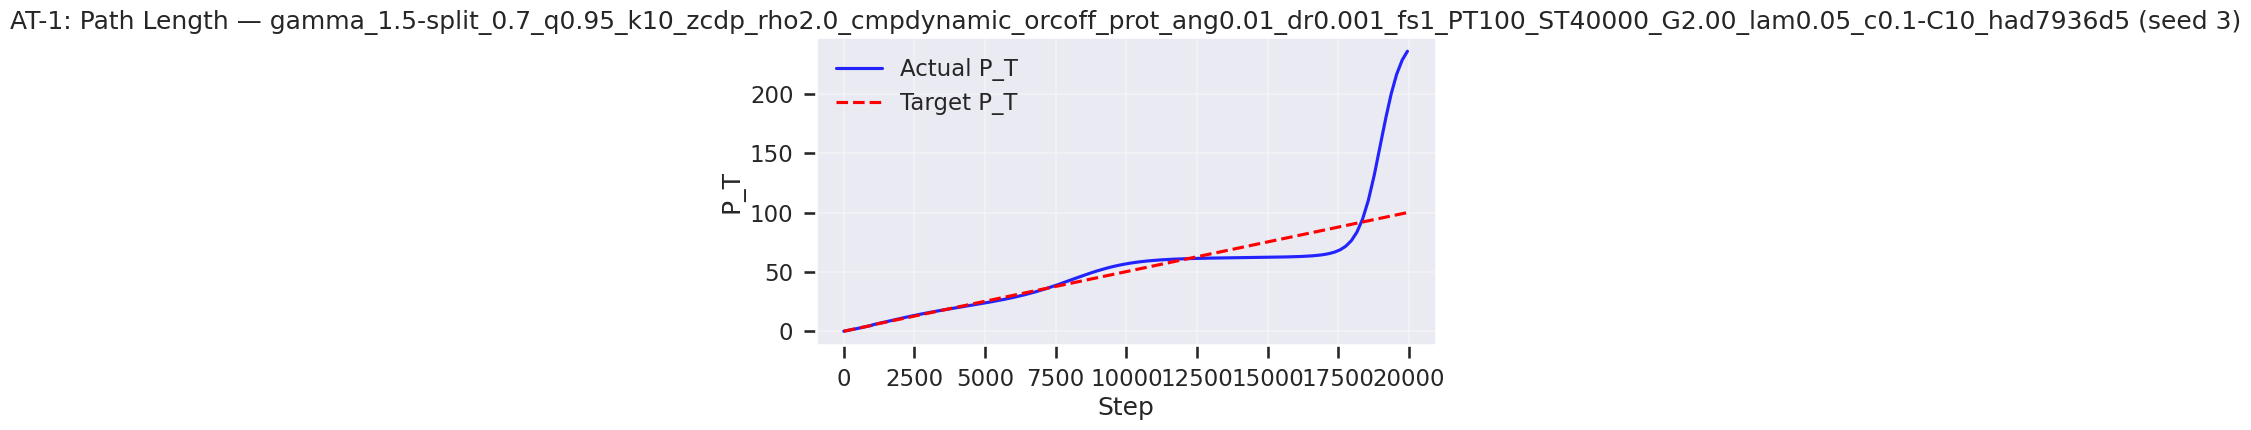

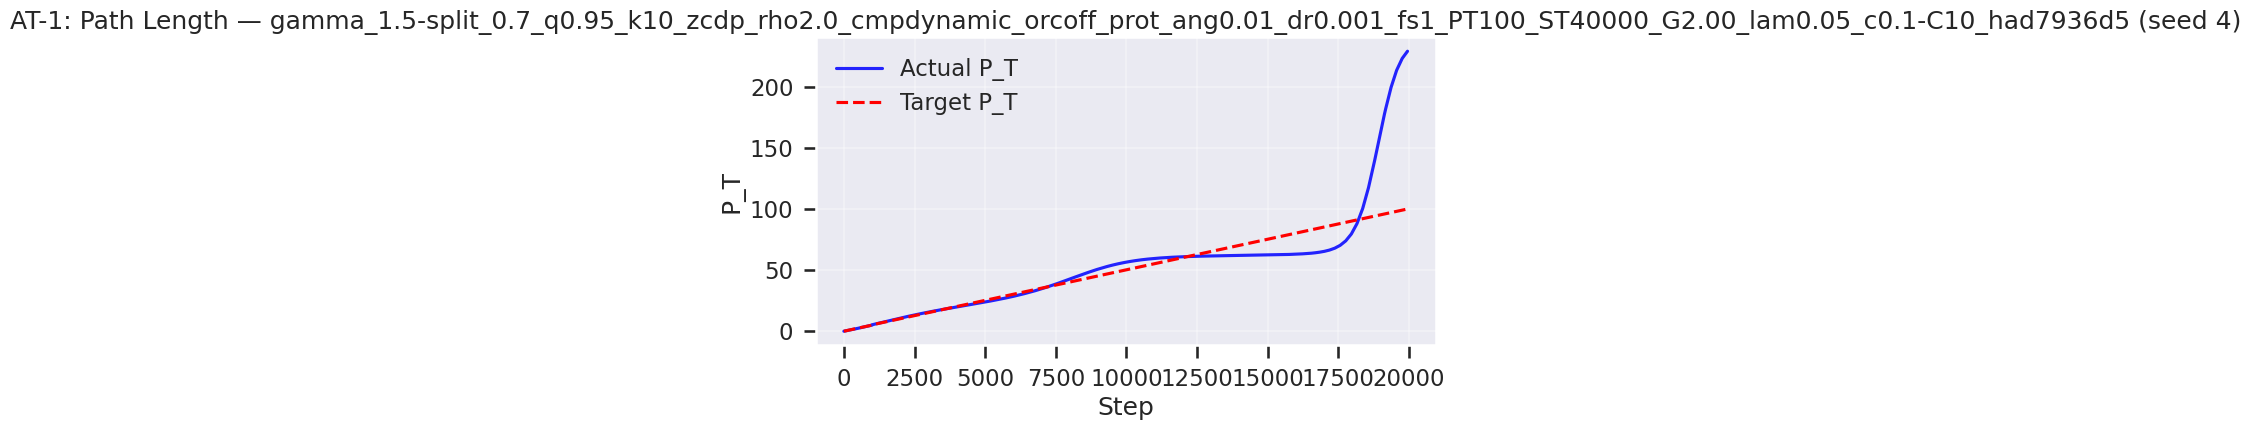


=== Grid: gamma_0.6-split_0.5_q0.95_k1_zcdp_rho0.5_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_PT250_ST40000_G2.00_lam0.05_c0.1-C10_h5b64ec2a ===
{'gamma_bar': 0.6, 'gamma_split': 0.5, 'algo': 'memorypair', 'accountant': 'zcdp', 'max_events': 20000, 'bootstrap_iters': 1000, 'delete_ratio': 1, 'rho_total': 0.5, 'delta_total': '1e-5', 'delta_b': 0.05, 'm_max': None, 'quantile': 0.95, 'D_cap': 10.0, 'ema_beta': 0.9, 'strong_convexity': True, 'lambda_reg': 0.05, 'lambda_': 0.05, 'dim': 20, 'path_style': 'rotating', 'target_G': 2.0, 'target_D': 2.0, 'target_c': 0.1, 'target_C': 10.0, 'target_lambda': 0.05, 'target_PT': 250.0, 'target_ST': 40000.0, 'enable_oracle': False, 'eps_total': 1.0, '__grid_path__': 'results/grid_2025_08_31_p4/sweep/gamma_0.6-split_0.5_q0.95_k1_zcdp_rho0.5_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_PT250_ST40000_G2.00_lam0.05_c0.1-C10_h5b64ec2a'}


,seed,avg_regret_empirical,N_star_emp,m_emp,PT_final,PT_error,ST_final,ST_error,max_g_norm,avg_clip_rate,rho_spent_final,blocked_reason
0,1,0.275151,9475,9475,NaN,NaN,212551.009219,4.313775,NaN,NaN,NaN,AT-5 ST err 431.4%
1,2,0.126832,9475,9475,560.829717,1.243319,39996.000000,0.000100,1.414214,0.0,0.0,AT-5 ST err 431.4%; AT-1 PT err 124.3%
2,3,0.005088,9359,9359,572.489735,1.289959,39994.000000,0.000150,1.414214,0.0,0.0,AT-5 ST err 431.4%; AT-1 PT err 129.0%
3,4,0.288632,8419,8418,571.193330,1.284773,39994.000000,0.000150,1.414214,0.0,0.0,AT-5 ST err 431.4%; AT-1 PT err 128.5%


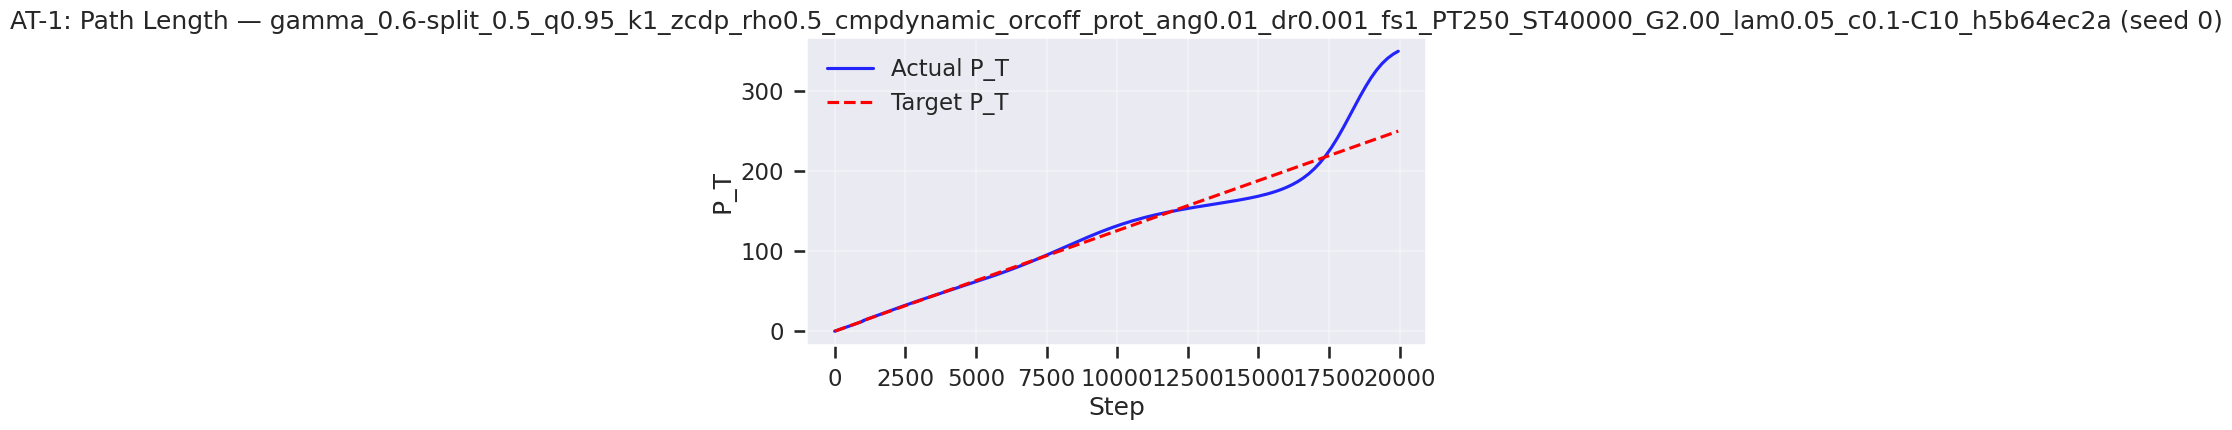

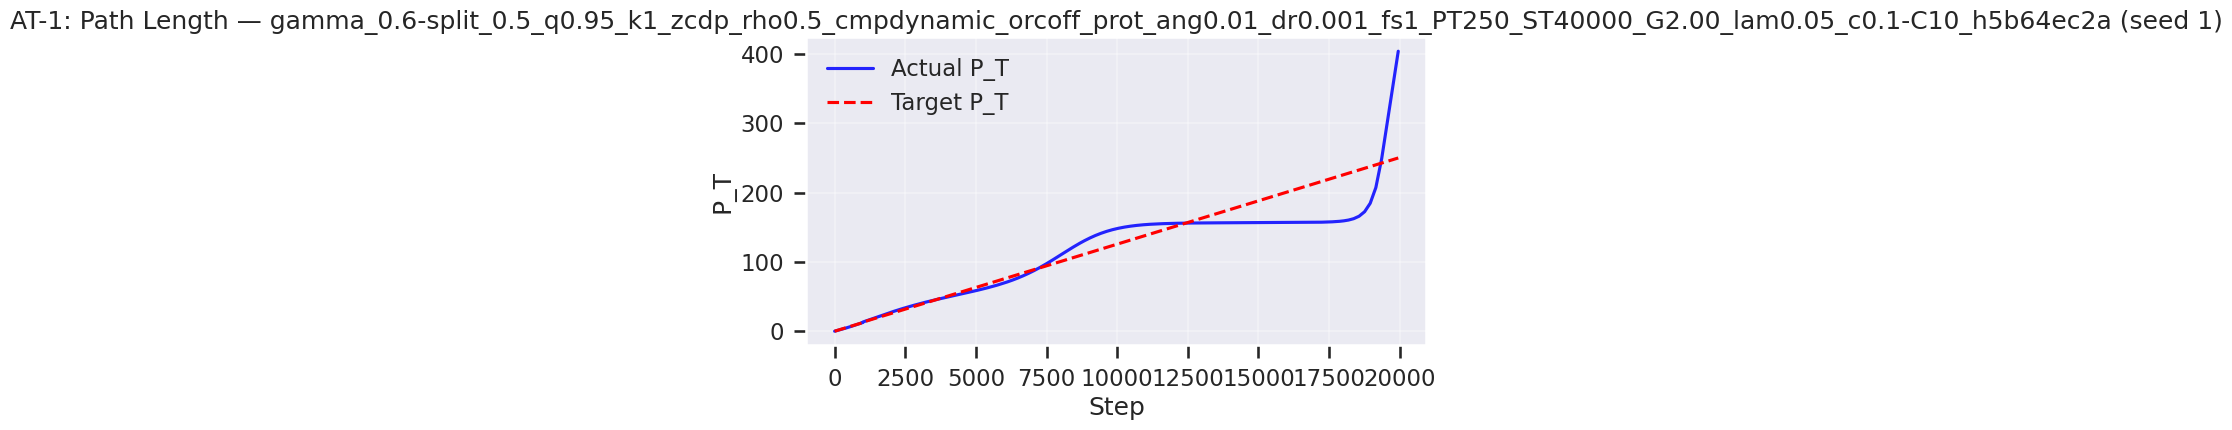

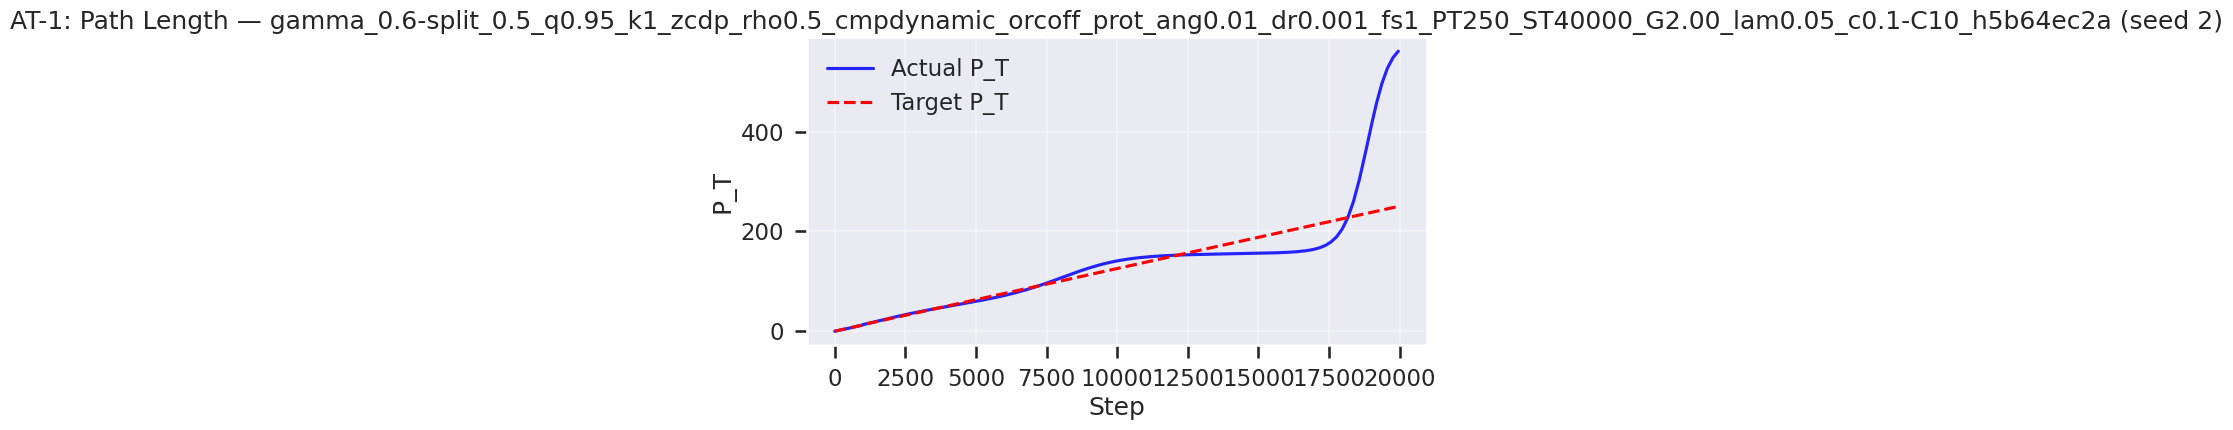

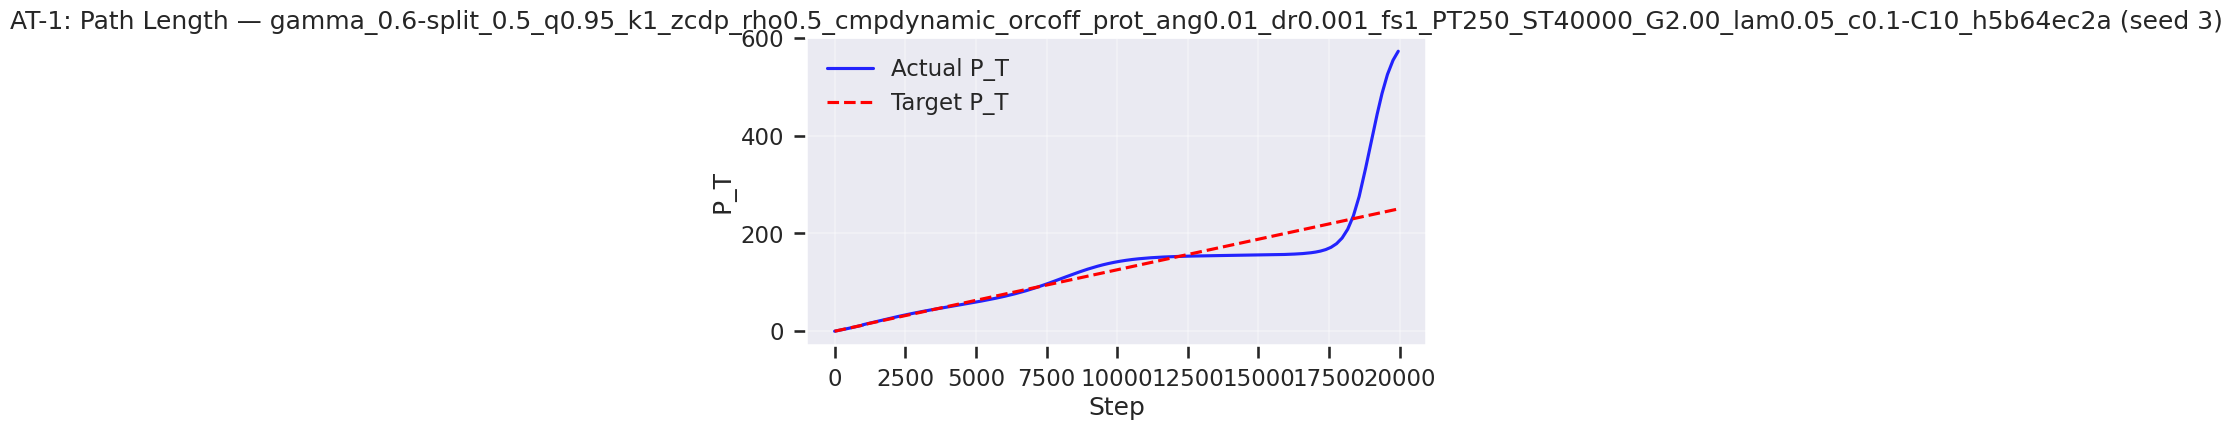

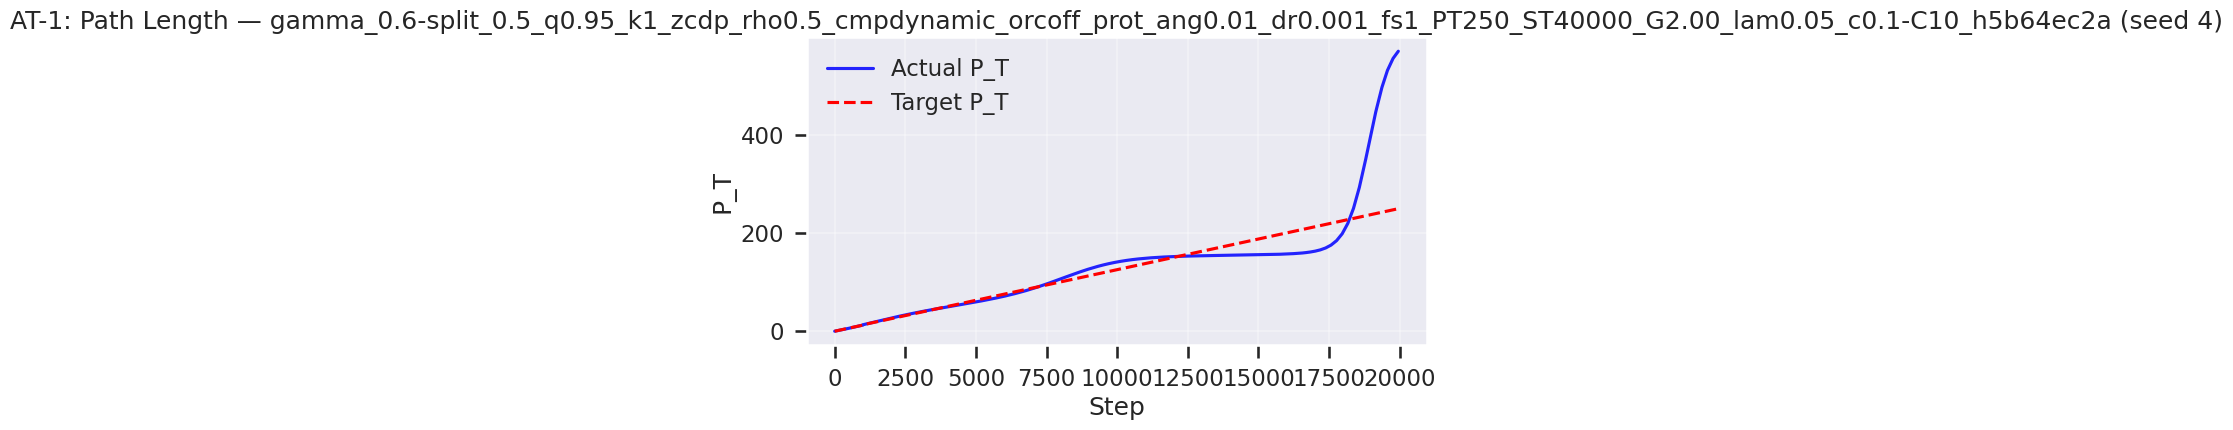


=== Grid: gamma_0.6-split_0.5_q0.95_k10_zcdp_rho0.5_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_PT250_ST40000_G2.00_lam0.05_c0.1-C10_ha4fd7e6b ===
{'gamma_bar': 0.6, 'gamma_split': 0.5, 'algo': 'memorypair', 'accountant': 'zcdp', 'max_events': 20000, 'bootstrap_iters': 1000, 'delete_ratio': 10, 'rho_total': 0.5, 'delta_total': '1e-5', 'delta_b': 0.05, 'm_max': None, 'quantile': 0.95, 'D_cap': 10.0, 'ema_beta': 0.9, 'strong_convexity': True, 'lambda_reg': 0.05, 'lambda_': 0.05, 'dim': 20, 'path_style': 'rotating', 'target_G': 2.0, 'target_D': 2.0, 'target_c': 0.1, 'target_C': 10.0, 'target_lambda': 0.05, 'target_PT': 250.0, 'target_ST': 40000.0, 'enable_oracle': False, 'eps_total': 1.0, '__grid_path__': 'results/grid_2025_08_31_p4/sweep/gamma_0.6-split_0.5_q0.95_k10_zcdp_rho0.5_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_PT250_ST40000_G2.00_lam0.05_c0.1-C10_ha4fd7e6b'}


,seed,avg_regret_empirical,N_star_emp,m_emp,PT_final,PT_error,ST_final,ST_error,max_g_norm,avg_clip_rate,rho_spent_final,blocked_reason
0,1,0.276541,17228,1722,NaN,NaN,367127.663211,8.178192,NaN,NaN,NaN,AT-5 ST err 817.8%
1,2,0.125039,17228,1722,560.829717,1.243319,39996.000000,0.000100,1.414214,0.0,0.0,AT-5 ST err 817.8%; AT-1 PT err 124.3%
2,3,0.003606,17017,1701,572.489735,1.289959,39994.000000,0.000150,1.414214,0.0,0.0,AT-5 ST err 817.8%; AT-1 PT err 129.0%
3,4,0.284835,15307,1530,571.193330,1.284773,39994.000000,0.000150,1.414214,0.0,0.0,AT-5 ST err 817.8%; AT-1 PT err 128.5%


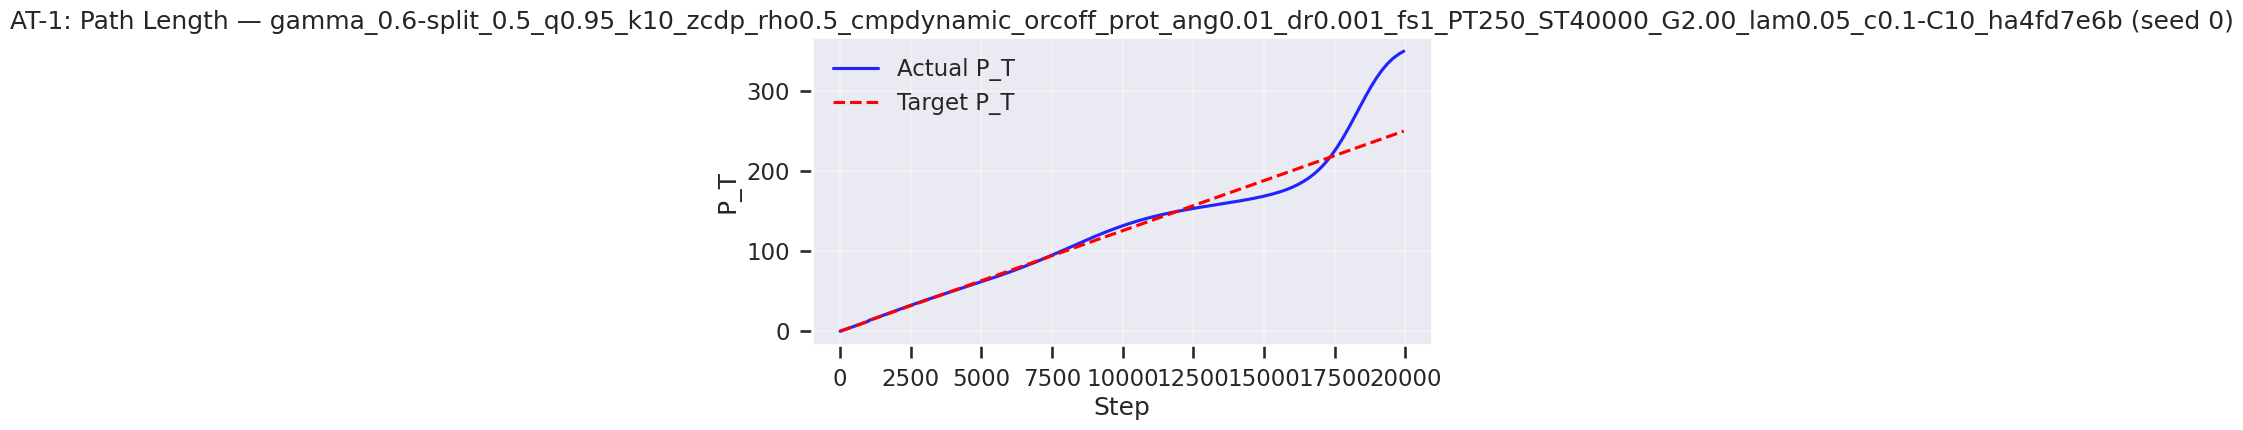

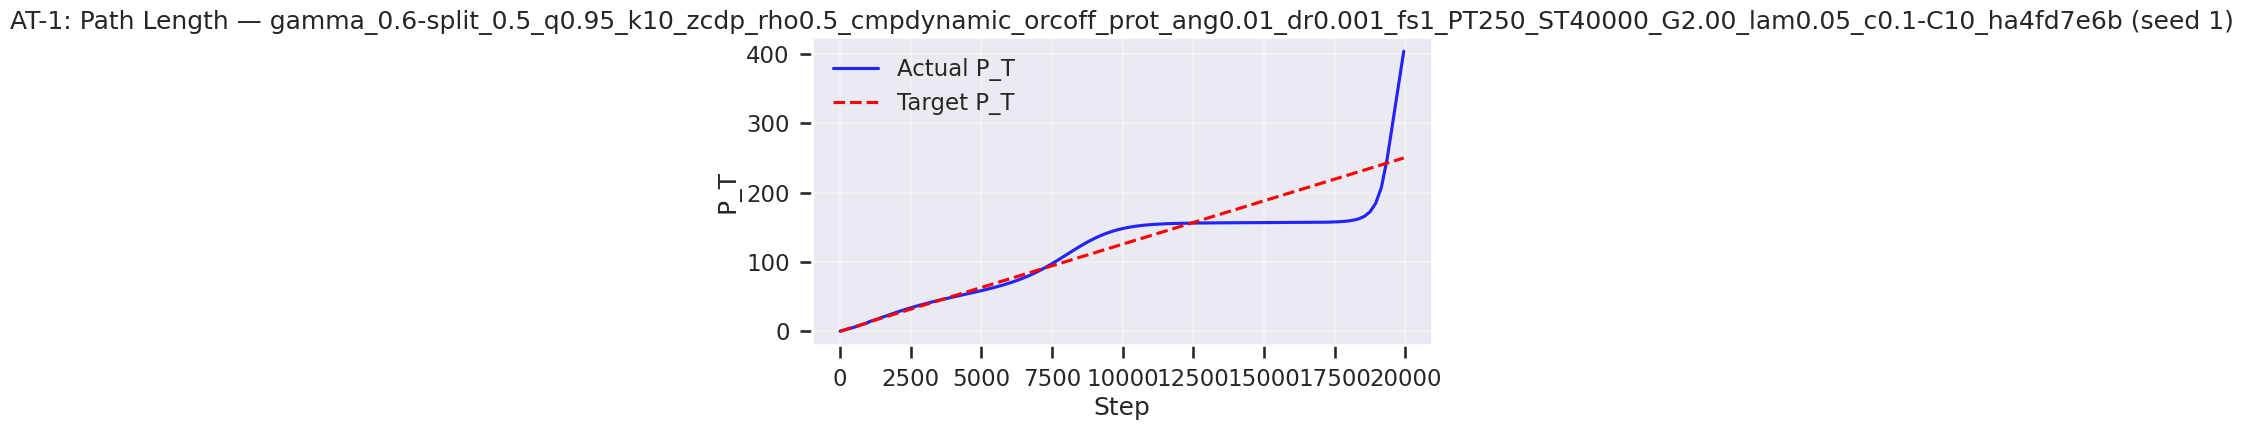

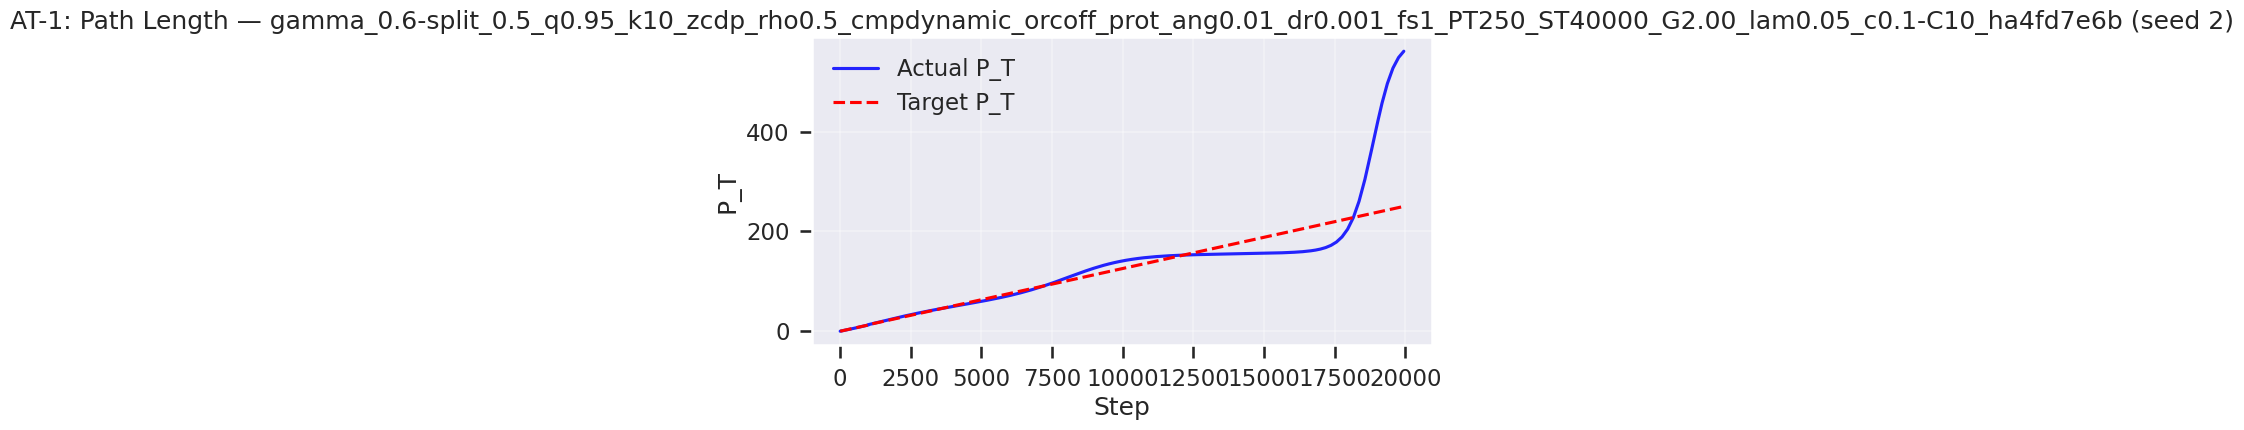

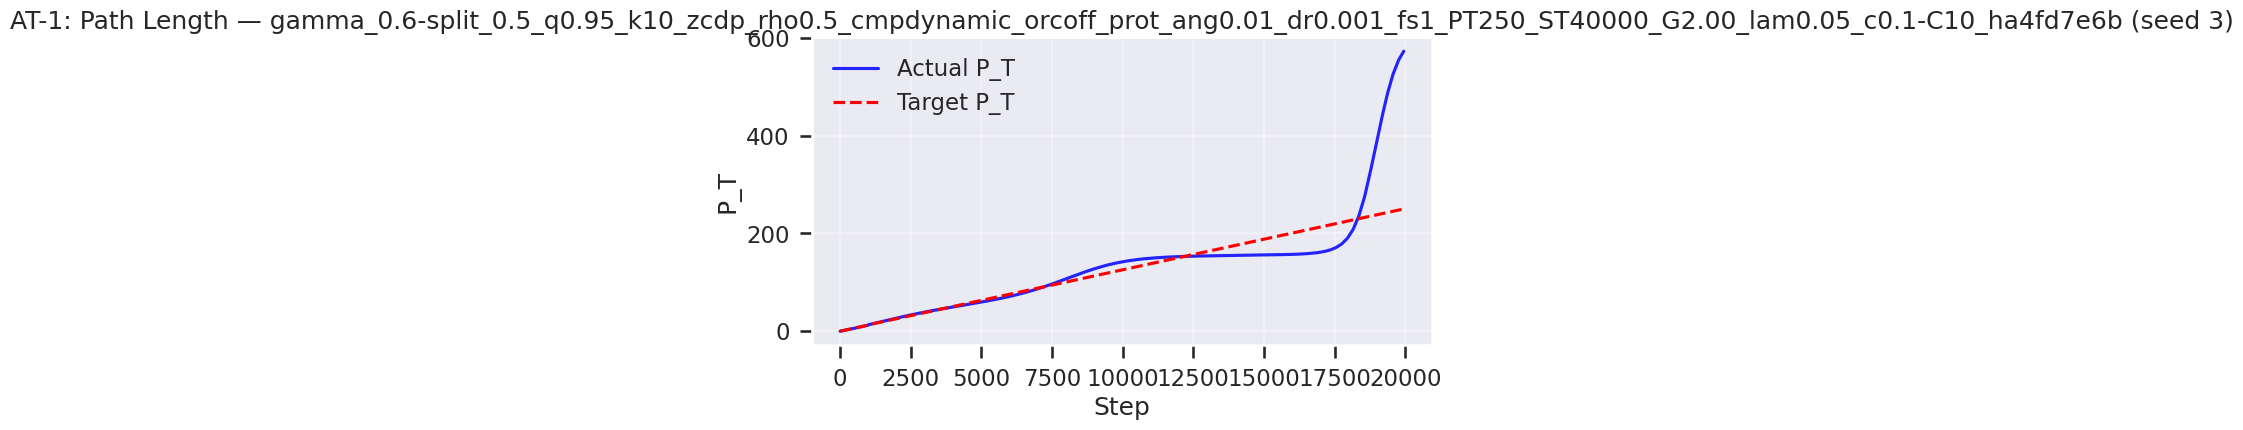

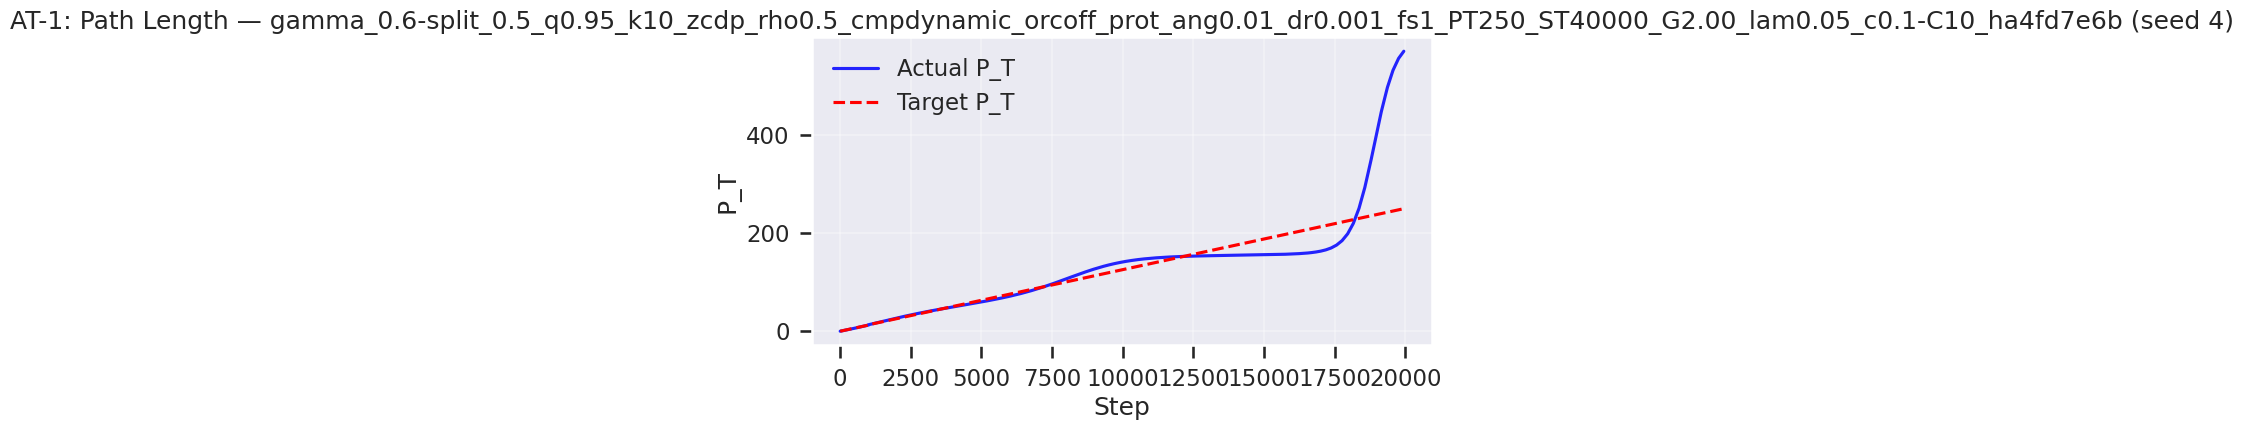

,PT_final,PT_error,ST_final,ST_error,max_g_norm,avg_clip_rate,rho_spent_final,AT1_PT,AT2_G_clip,AT5_ST,AT6_privacy,grid_id
0,229.056395,1.290564,39996.0,0.00010,1.414214,0.0,0.0,False,True,True,True,gamma_1.5-split_0.7_q0.95_k10_zcdp_rho2.0_cmpd...
1,571.193330,1.284773,39994.0,0.00015,1.414214,0.0,0.0,False,True,True,True,gamma_0.6-split_0.5_q0.95_k1_zcdp_rho0.5_cmpdy...
2,571.193330,1.284773,39994.0,0.00015,1.414214,0.0,0.0,False,True,True,True,gamma_0.6-split_0.5_q0.95_k10_zcdp_rho0.5_cmpd...


In [8]:
all_metrics = []
grid_summaries = []

for g in sampled:
    params = load_params(g)
    params["__grid_path__"] = g
    grid_id = os.path.basename(g)
    print(f"\n=== Grid: {grid_id} ===")
    print(params)

    # Seed-level summaries (if produced by agents/process_seed_output)
    seed_df = load_seed_summary(g)
    if not seed_df.empty:
        # small view of top columns if present
        cols_show = [c for c in ["seed","avg_regret_empirical","N_star_emp","m_emp","PT_final","PT_error","ST_final","ST_error","max_g_norm","avg_clip_rate","rho_spent_final","blocked_reason"] if c in seed_df.columns]
        display(seed_df[cols_show])

    # Event-level loading (robust)
    usecols = None  # keep all for now; set to a reduced list to speed up
    ev = load_event_csvs(g, usecols=usecols)
    if ev.empty:
        print("No event-level data found.")
        continue

    # Compute acceptance metrics from events
    metrics = compute_acceptance_metrics(ev, params)
    metrics["grid_id"] = grid_id
    all_metrics.append(metrics)

    # Per-seed path length charts (AT-1)
    if "seed" in ev.columns:
        for sid, df_seed in ev.groupby("seed"):
            has_PT = "P_T_true" in df_seed.columns
            if not has_PT:
                print(f"Seed {sid}: No P_T_true column to plot.")
                continue

            T_seed = len(df_seed)
            steps = np.arange(T_seed)
            fig, ax = plt.subplots(1, 1, figsize=(8, 4))
            ax.plot(steps, df_seed["P_T_true"].values, 'b-', alpha=0.85, label='Actual P_T')

            # Target line scaled by event ids over nominal horizon
            if np.isfinite(params.get("target_PT", np.nan)):
                T_nom = params.get("max_events", T_seed)
                events_axis = df_seed["event"].values if "event" in df_seed.columns else steps
                ax.plot(steps, params["target_PT"] * events_axis / max(T_nom, 1), 'r--', label='Target P_T')

            seed_lbl = int(sid) if pd.notna(sid) else sid
            ax.set_title(f"AT-1: Path Length — {grid_id} (seed {seed_lbl})")
            ax.set_xlabel("Step"); ax.set_ylabel("P_T")
            ax.grid(True, alpha=0.3); ax.legend()
            plt.show()
    else:
        # Fallback: single-seed style visualization
        quick_panel_plots(ev, params, title=f"{grid_id}")

# Aggregate acceptance metrics across the 3 cells
acc_df = pd.DataFrame(all_metrics)
display(acc_df)

## Analyzing the Results

The thing that stands out to me the most is the strange behavior of the AdaGrad energy and Path Length plots. It looks like the code is concatenating multiple seeds together in sequence. The visualization then assumes that this is a single progression of events over a single stream.

Any future analysis should visualize $P_{T}$ and $S_{T}$ on a seed granularity to best show the growth of path length in relation to the theoretical ideal.